In [66]:
import keras.metrics
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import models, layers
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Reshape, BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import keras
import tensorflow as tf
import os

In [117]:
def windowing(x, y, window_size, overlap):
    windows = []
    y_labels = []

    step_size = window_size - overlap

    for i in range(0, len(x) - window_size + 1, step_size):
        window = x.iloc[i:(i + window_size), :]
        windows.append(window)

        if np.sum(y[i:i + window_size] == 1) >= 3:
            y_labels.append(1)
        else:
            y_labels.append(0)

    return np.array(windows), np.array(y_labels)

In [118]:
data_path = '/Users/helenamehler/PycharmProjects/fallDetection/dataSets/SisFall_labelled'
dfs = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        file_path = os.path.join(root, file)
        dfs.append(pd.read_csv(file_path, index_col=0))

In [119]:
window_size = 200
overlap = 50

In [120]:
windowed_x = []
windowed_y = []
for i, dataset in enumerate(dfs):
    x_w, y_w = windowing(dataset.drop(columns = ['fall']), dataset['fall'], window_size, overlap)
    windowed_x.extend(x_w)
    windowed_y.extend(y_w)

In [121]:
x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(windowed_x)):
    if np.random.rand(1)[0] < 0.2:
        x_test.append(windowed_x[i])
        y_test.append(windowed_y[i])
    else:
        x_train.append(windowed_x[i])

        y_train.append(windowed_y[i])

In [122]:
scaler = MinMaxScaler()

x_train = np.array(x_train)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)

x_test = np.array(x_test)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [123]:
y_trainCat = to_categorical(y_train, num_classes=2)

In [124]:
input_shape = (200, 3)  # Specify your input shape

model = models.Sequential()

# Layer 1: Fully Connected (w x 3)
model.add(Dense(3, activation='relu', input_shape=input_shape))

# Layer 2: Batch Normalization (w x 32)
model.add(BatchNormalization())

# Layer 3: Dropout (w x 32)
model.add(Dropout(0.5))  # Adjust dropout rate as needed

# Layer 6: LSTM (w x 32)
model.add(LSTM(32, activation='relu', return_sequences=False))  # Changed return_sequences to False

# Layer 7: Dropout (w x 32)
model.add(Dropout(0.5))  # Adjust dropout rate as needed

# Layer 8: Fully Connected (1 x 32)
model.add(Dense(32, activation='relu'))

# Layer 9: Sigmoid (1 x 2)
model.add(Dense(2, activation='sigmoid'))  # Modified for 2 units and sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [128]:
input = (200, 3)
model = models.Sequential()
model.add(layers.Conv1D(6, kernel_size=4, activation='relu', input_shape=input, padding='same'))

model.add(layers.MaxPooling1D(pool_size=4, strides=4))

model.add(layers.Conv1D(12, kernel_size=4, activation='relu',padding='same'))

model.add(layers.MaxPooling1D(pool_size=4, strides=4))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [129]:
batch = 80
epochs = 40
iterationsPerEp = x_train.shape[0] // batch

model.fit(x_train, y_trainCat, batch_size=batch, epochs=epochs, steps_per_epoch=iterationsPerEp)

Epoch 1/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.2406 - accuracy: 0.9365
Epoch 2/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.2271 - accuracy: 0.9380
Epoch 3/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.2007 - accuracy: 0.9445
Epoch 4/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.1820 - accuracy: 0.9498
Epoch 5/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.1628 - accuracy: 0.9535
Epoch 6/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.1483 - accuracy: 0.9563
Epoch 7/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.1438 - accuracy: 0.9581
Epoch 8/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.1393 - accuracy: 0.9591
Epoch 9/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.1373 - accuracy: 0.9593
Epoch 10/40
1014/1014 [==============================] - 3s 3ms/step - loss: 0.133

In [130]:
predictions = model.predict(x_test)
yPredClasses = np.argmax(predictions, axis=1)
confMat = confusion_matrix(y_test, yPredClasses)
confMat

628/628 [==============================] - 1s 1ms/step


array([[18649,   137],
       [  487,   794]])

In [131]:
print('Accuracy', accuracy_score(y_test, yPredClasses))
print('F1-Score', f1_score(y_test, yPredClasses))

Accuracy 0.9689041710270594
F1-Score 0.7179023508137432


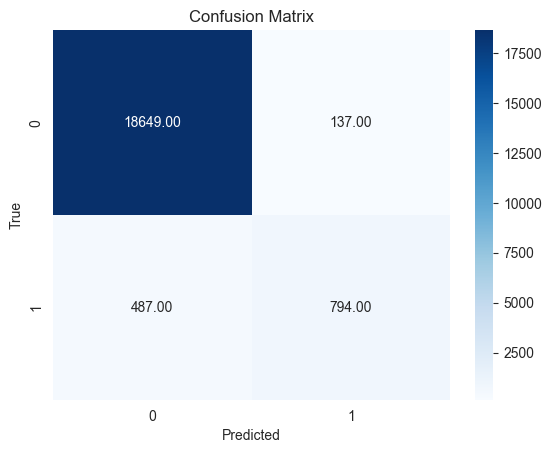

In [133]:
plt.figure()
sns.heatmap(confMat.astype('int') , annot=True, fmt='0.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()